In [1]:
###성공###
import sys
sys.path.append('/home/lgm/JEONGHO/RL스터디2020/')
import tensorflow as tf
import numpy as np
import gym
import dobroEnv
import random
from collections import deque
import time

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

# from halfCheetah import HalfCheetah

/home/lgm/anaconda3/envs/mujoco_pjh/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lgm/anaconda3/envs/mujoco_pjh/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lgm/anaconda3/envs/mujoco_pjh/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lgm/anaconda3/envs/mujoco_pjh/lib/pyt

In [2]:
# env = gym.make('DobroHalfCheetah-v0')
# env.unwrapped.initialize(is_render=True) # renderin하려면.
GAME_NAME = 'HalfCheetah-v3'

env = gym.make(GAME_NAME)
eval_env = gym.make(GAME_NAME)

MAX_EPISODE =300
REPLAY_BUFFER_SIZE = 100000
BATCH_SIZE = 128
GAMMA = 0.99
ALPHA = 0.1
BETA = 0.1
SOFT_UPDATA_TAU = 0.001
STATE_DIM = env.observation_space.shape[0]
ACTION_DIM = env.action_space.shape[0]
Policy_LR = 3e-4
Qnet_LR = 3e-4
MIN_REPLAY_SIZE = 3000

In [3]:
env.action_space.sample()

array([-0.4201029 , -0.4592422 , -0.5986772 , -0.3189302 ,  0.10325069,
       -0.11548314], dtype=float32)

In [4]:
class ReplayBuffer():
    def __init__(self, buffer_size):
        self.history = deque([], maxlen = buffer_size)
    def update(self, state, action, reward, next_state, done):
        buffer = (state, action, reward, next_state, done)
        self.history.append(buffer)
        
    def sample_batch(self, batch_size):
        batch = random.sample(self.history, batch_size)
        return batch

In [5]:
class Agent():
    def __init__(self):
        self.replay = ReplayBuffer(REPLAY_BUFFER_SIZE)
        self.gamma = GAMMA
        self.alpha = ALPHA
        self.betha = BETA 
        self.tau = SOFT_UPDATA_TAU
        self.state_dim = STATE_DIM
        self.action_dim = ACTION_DIM
        self.batch_size = BATCH_SIZE
        self.minimum_replay_size = MIN_REPLAY_SIZE
        self.eval_count = 0
        
        self.PolicyOptimizer = tf.train.AdamOptimizer(learning_rate=Policy_LR)
        self.QnetOptimizer = tf.train.AdamOptimizer(learning_rate=Qnet_LR)
        
        with tf.variable_scope('SACagent'):
            self.state_ph = tf.placeholder(tf.float32, shape=(None, self.state_dim), name='state_ph')
            self.action_ph = tf.placeholder(tf.float32, shape=(None, self.action_dim), name='action_ph')
            self.sample_action_ph = tf.placeholder(tf.float32, shape=(None, self.action_dim), name='sample_action_ph')
            self.action_eps_ph = tf.placeholder(tf.float32, shape=(None,self.action_dim), name='eps_ph')
            self.action_std_ph = tf.placeholder(tf.float32, shape=(None,self.action_dim), name='std_ph')
            
            self._build_policy()
            self._build_qnet()
            
            self.policy_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'SACagent/policy')

            self.qnet1_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'SACagent/onlineq1')
            self.qnet2_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'SACagent/onlineq2')
            self.qnet1_target_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'SACagent/targetq1')
            self.qnet2_target_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'SACagent/targetq2')
            self.qnet_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'SACagent/onlineq')
            
            self.q1_target_update_ops, self.q2_target_update_ops = self._build_q_target_update_ops()
            

            self.reward_ph = tf.placeholder(tf.float32, (None,1), name='reward_ph')
            self.done_ph = tf.cast(tf.placeholder(tf.bool, (None,1), name='done_ph'), tf.float32)

            
            #self.log_policy = - 0.5 * tf.log(1e-8+(2.*np.pi * self.action_std**2)) \
             #                       - 0.5 * (self.action_eps_ph)**2 \
               #                     - tf.expand_dims(tf.reduce_sum(tf.log(1e-8+1 - tf.square(self.action)),axis=1),1)#sampling된 액션1(from current state of buffer)

            #self.log_policy_next = - 0.5 * tf.log(1e-8+(2.*np.pi * self.action_std_ph**2)) \
             #                               - 0.5 * (self.action_eps_ph)**2 \
             #                               - tf.expand_dims(tf.reduce_sum(tf.log(1e-8+1 - tf.square(self.action_ph)),axis=1),1)#sampling 된 액션2 (from next_state of buffer)
            self.log_policy =  -0.5 * tf.log(1e-8 + (2.*np.pi * self.action_std**2)) -0.5*(self.action_eps_ph)**2 - tf.expand_dims(tf.reduce_sum(2*(np.log(2) - self.action - tf.nn.softplus(-2*self.action)), axis=1),1)
            self.log_policy_next =  -0.5 * tf.log(1e-8 + (2.*np.pi * self.action_std_ph**2)) -0.5*(self.action_eps_ph)**2 - tf.expand_dims(tf.reduce_sum(2*(np.log(2) - self.action_ph - tf.nn.softplus(-2*self.action_ph)), axis=1),1)
            
            
            self.qnet_target = self.reward_ph + self.gamma * (1 - self.done_ph) * (self.qmin_target - self.alpha * self.log_policy_next) # 전부 샘플링된 액션2 (from next_state of buffer)
            self.qnet_target_ph = tf.placeholder(tf.float32, shape=(None, self.action_dim), name='qnet_target_ph')

            # 폴리시 LOSS
            self.policy_loss = tf.reduce_mean(self.alpha * self.log_policy - self.qmin_backprop)
        
            # q네트워크 LOSS
            self.qnet1_loss = tf.reduce_mean(tf.square(self.q_value1 - self.qnet_target_ph)) # q_value1: buffer's current action, current state
            self.qnet2_loss = tf.reduce_mean(tf.square(self.q_value2 - self.qnet_target_ph)) 
            self.qnet_loss = self.qnet1_loss + self.qnet2_loss

            self.qnet_update = self.QnetOptimizer.minimize(self.qnet_loss, var_list=self.qnet_vars)
            
            self.policy_update = self.PolicyOptimizer.minimize(self.policy_loss, var_list=self.policy_vars)
#         print('HHHHHHHHHHHHHHHHHHHHHHHHHHHHH')
#         self.q_initial_sync()
            
            
            
            
    def _build_qnet(self):
        LAYER_SIZE = 128
        init_mu = 0.
        init_std = 0.03
        qnet_input = tf.concat([self.state_ph, self.action_ph], axis=1)
        with tf.variable_scope('onlineq1'):
            qnet_hid11 = tf.layers.dense(inputs=qnet_input, units=LAYER_SIZE, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer= tf.compat.v1.initializers.random_normal(init_mu,init_std),name='q1_h1')
            qnet_hid11 = tf.nn.relu(qnet_hid11)
            qnet_hid12 = tf.layers.dense(inputs=qnet_hid11, units=LAYER_SIZE, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std),name='q1_h2')
            qnet_hid12 = tf.nn.relu(qnet_hid12)

            self.q_value1 = tf.layers.dense(inputs=qnet_hid12, units=self.action_dim, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer= tf.compat.v1.initializers.random_normal(init_mu,init_std),name='q1_h3')
        
        with tf.variable_scope('onlineq2'):
            qnet_hid21 = tf.layers.dense(inputs=qnet_input, units=LAYER_SIZE, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std),name='q2_h1')
            qnet_hid21 = tf.nn.relu(qnet_hid21)
            qnet_hid22 = tf.layers.dense(inputs=qnet_hid21, units=LAYER_SIZE, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer= tf.compat.v1.initializers.random_normal(init_mu,init_std),name='q2_h2')
            qnet_hid22 = tf.nn.relu(qnet_hid22)

            self.q_value2 = tf.layers.dense(inputs=qnet_hid22, units=self.action_dim, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std),name='q2_h3')
        self.qmin = tf.minimum(self.q_value1, self.q_value2)
        
        qnet_target_input = tf.concat([self.state_ph, self.sample_action_ph], axis=1)
        with tf.variable_scope('targetq1'):
            qnet_target_hid11 = tf.layers.dense(inputs=qnet_target_input, units=LAYER_SIZE, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std),name='qt1_h1')
            qnet_target_hid11 = tf.nn.relu(qnet_target_hid11)
            qnet_target_hid12 = tf.layers.dense(inputs=qnet_target_hid11, units=LAYER_SIZE, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std),name='qt1_h2')
            qnet_target_hid12 = tf.nn.relu(qnet_target_hid12)

            self.q_value1_target = tf.layers.dense(inputs=qnet_target_hid12, units=self.action_dim, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer= tf.compat.v1.initializers.random_normal(init_mu,init_std),name='qt1_h3')
        
        with tf.variable_scope('targetq2'):
            qnet_target_hid21 = tf.layers.dense(inputs=qnet_target_input, units=LAYER_SIZE, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer= tf.compat.v1.initializers.random_normal(init_mu,init_std),name='qt2_h1')
            qnet_target_hid21 = tf.nn.relu(qnet_target_hid21)
            qnet_target_hid22 = tf.layers.dense(inputs=qnet_target_hid21, units=LAYER_SIZE, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer= tf.compat.v1.initializers.random_normal(init_mu,init_std),name='qt2_h2')
            qnet_target_hid22 = tf.nn.relu(qnet_target_hid22)

            self.q_value2_target = tf.layers.dense(inputs=qnet_target_hid22, units=self.action_dim, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer= tf.compat.v1.initializers.random_normal(init_mu,init_std),name='qt2_h3')
        self.qmin_target = tf.minimum(self.q_value1_target, self.q_value2_target)
        
        #### q에 들어가는 action이 self.action이어서 grad가 back prop되는 q들
        qnetg_input = tf.concat([self.state_ph, self.action], axis=1)
        with tf.variable_scope('onlineq1', reuse=True):
            qnetg_hid11 = tf.layers.dense(inputs=qnetg_input, units=LAYER_SIZE, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer= tf.compat.v1.initializers.random_normal(init_mu,init_std),name='q1_h1')
            qnetg_hid11 = tf.nn.relu(qnetg_hid11)
            qnetg_hid12 = tf.layers.dense(inputs=qnetg_hid11, units=LAYER_SIZE, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std),name='q1_h2')
            qnetg_hid12 = tf.nn.relu(qnetg_hid12)

            self.q_value1_copy = tf.layers.dense(inputs=qnetg_hid12, units=self.action_dim, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer= tf.compat.v1.initializers.random_normal(init_mu,init_std),name='q1_h3')
        with tf.variable_scope('onlineq2', reuse=True):
            qnetg_hid21 = tf.layers.dense(inputs=qnetg_input, units=LAYER_SIZE, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std),name='q2_h1')
            qnetg_hid21 = tf.nn.relu(qnetg_hid21)
            qnetg_hid22 = tf.layers.dense(inputs=qnetg_hid21, units=LAYER_SIZE, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer= tf.compat.v1.initializers.random_normal(init_mu,init_std),name='q2_h2')
            qnetg_hid22 = tf.nn.relu(qnetg_hid22)

            self.q_value2_copy = tf.layers.dense(inputs=qnetg_hid22, units=self.action_dim, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std),name='q2_h3')
        self.qmin_backprop = tf.minimum(self.q_value1_copy, self.q_value2_copy)
        
    def _build_policy(self):
        LAYER_SIZE = 128
        init_mu = 0.
        init_std = 0.03
        with tf.variable_scope('policy'):
            policy_hid1 = tf.layers.dense(inputs=self.state_ph, units=LAYER_SIZE, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std))
            policy_hid1 = tf.nn.relu(policy_hid1)
            
            policy_hid2 = tf.layers.dense(inputs=policy_hid1, units=LAYER_SIZE, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer= tf.compat.v1.initializers.random_normal(init_mu,init_std))
            policy_hid2 = tf.nn.relu(policy_hid2)
            
            self.action_mu = tf.layers.dense(inputs=policy_hid2, units=self.action_dim, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std))
            self.action_std = tf.layers.dense(inputs=policy_hid2, units=self.action_dim, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer= tf.compat.v1.initializers.random_normal(init_mu,init_std))
#             self.action_std = tf.nn.softplus(self.action_std)
            self.action_std = tf.clip_by_value(self.action_std, -20,2)
            self.action_std = tf.exp(self.action_std)
            


            self.unbounded_action = self.action_mu + self.action_std * self.action_eps_ph
            self.action = tf.nn.tanh(self.unbounded_action)



    def q_initial_sync(self):
        ops1 = []
        for target_var, online_var in zip(self.qnet1_target_vars, self.qnet1_vars):
            ops1.append(target_var.assign(online_var))
        ops2 = []
        for target_var, online_var in zip(self.qnet2_target_vars, self.qnet2_vars):
            ops2.append(target_var.assign(online_var))
        for op in ops1:
            sess.run(op)
        for op in ops2:
            sess.run(op)
        print('#########################\nQ net initially sync done\n#########################')
        
    def _build_q_target_update_ops(self):
        ops1 = []
        for target_var, online_var in zip(self.qnet1_target_vars, self.qnet1_vars):
            ops1.append(target_var.assign(self.tau * online_var + (1-self.tau) * target_var))
        ops2 = []
        
        for target_var, online_var in zip(self.qnet2_target_vars, self.qnet2_vars):
            ops2.append(target_var.assign(self.tau * online_var + (1-self.tau) * target_var))
        return ops1, ops2

    
    def q_target_update(self):
        for op in self.q1_target_update_ops:
            sess.run(op)
        for op in self.q2_target_update_ops:
            sess.run(op)
    
        
    def sample_action(self, state, Train=False):
        if Train:
            eps = self.sample_action_eps(Train=True)
            
            action = sess.run(self.action, feed_dict={self.state_ph:state, self.action_eps_ph:eps})

            return action, eps
        else:
            if len(self.replay.history) < self.minimum_replay_size:
                action = [env.action_space.sample()]

                ua = action
            else:
                eps = self.sample_action_eps()
                action, ua = sess.run([self.action,self.unbounded_action], feed_dict={self.state_ph:[state], self.action_eps_ph:[eps]})

            return action, ua
    
    def sample_action_eval(self, state):
#         eps = self.sample_action_eps()
        action = sess.run(self.action_mu, feed_dict={self.state_ph:[state]})
    
        return np.tanh(action)

        
    def sample_action_eps(self, Train=False):
        if Train:
            action_eps = np.random.normal(size=(self.batch_size, self.action_dim))
#             print('예시', action_eps)
        else:
            action_eps = np.random.normal(size=self.action_dim) # shape 아마 틀릴듯
        return action_eps
    
    def sample_batch(self):
        batch = self.replay.sample_batch(self.batch_size)
        return batch
    

        
    
        
    def train_policy(self, states,actions,rewards,next_states,dones):

        eps = self.sample_action_eps(Train=True)

        feed_dict = {self.state_ph:states, self.action_eps_ph:eps}
        _, ploss = sess.run([self.policy_update, self.policy_loss], feed_dict=feed_dict)

        return ploss
    
    def train_qnet(self, states,actions,rewards,next_states,dones):

        eps = self.sample_action_eps(Train=True)

        next_actions, stds = sess.run([self.action, self.action_std], feed_dict={self.state_ph:next_states, self.action_eps_ph:eps})
        targets = sess.run(self.qnet_target, feed_dict={self.reward_ph:rewards, self.done_ph: dones, self.state_ph:next_states, self.action_eps_ph:eps, self.sample_action_ph:next_actions, self.action_ph:next_actions, self.action_std_ph:stds})

        _, qloss = sess.run([self.qnet_update, self.qnet_loss], feed_dict={self.state_ph:states, self.action_ph:actions, self.qnet_target_ph:targets})
        self.q_target_update()

        
        return qloss
        

    def train(self):
        if len(self.replay.history) < self.minimum_replay_size:
            return 1,1
        batches = self.sample_batch()
        states, actions, rewards, next_states, dones = [],[],[],[],[]
        for batch in batches:
            states.append(batch[0])
            actions.append(batch[1])
            rewards.append(batch[2])
            next_states.append(batch[3])

            dones.append(batch[4])

        qloss = self.train_qnet(states,actions,rewards,next_states,dones)
        ploss = self.train_policy(states,actions,rewards,next_states,dones)
#         ploss = 1
        
        return qloss, ploss
    
    def evaluate(self):
        self.eval_count += 1
        eval_s = eval_env.reset()
        eval_score = 0
        eval_step = 0
        while True:
            eval_step += 1
            time.sleep(0.002)
            eval_a = self.sample_action_eval(eval_s)
#             eval_a = self.sample_action(eval_s)
            eval_ns, eval_r, eval_d, info = eval_env.step(eval_a[0])
            eval_score += eval_r
            eval_s = eval_ns
            if eval_d:
                print(self.eval_count, '-th evaluation done. score:' ,eval_score, 'step:', eval_step)
                break
        
        return eval_score
        
    
    


In [6]:
import time
tf.reset_default_graph()


sess = tf.Session()
agent = Agent()

sess.run(tf.global_variables_initializer())
agent.q_initial_sync()
## TRAIN ##
eval_scores = []
training_scores = []
for episode in range(MAX_EPISODE):
    state = env.reset()

#     eps = [[np.random.normal(agent.action_dim)]]
#     aa = sess.run(agent.action, feed_dict={agent.state_ph:[state], agent.action_eps_ph:eps})
#     d=sess.run(agent.log_policy, feed_dict={agent.state_ph:[state], agent.action_ph:aa, agent.action_eps_ph:eps})
#     print('d',d)
#     print('sat',state)
    score = 0
    step = 0
    while True:
        action, ua = agent.sample_action(state)
        
#         if episode%10==0:
#             env.render()
#             time.sleep(0.01)
        next_state, reward, done, info = env.step(action[0])
        fake_done = False
        time.sleep(.002)
#         env.render()
#         time.sleep(0.01)
        agent.replay.update(state, action[0], [reward], next_state, [fake_done])
#         print('nn',next_state)
        qloss, ploss = agent.train()


        step += 1
        score += reward
        state = next_state
        if done or step>2000:
            training_scores.append(score)
            print('step', step, 'score', score, 'qloss', qloss,'ploss',ploss)
            print('ac', action, 'ua', ua)
            print
            break
    
    eval_score = agent.evaluate()
    eval_scores.append(eval_score)

    





#########################
Q net initially sync done
#########################
step 1000 score -183.04500398545528 qloss 1 ploss 1
ac [array([-0.4038952 , -0.35874572, -0.05723584,  0.69171536,  0.91077   ,
       -0.17818804], dtype=float32)] ua [array([-0.4038952 , -0.35874572, -0.05723584,  0.69171536,  0.91077   ,
       -0.17818804], dtype=float32)]
1 -th evaluation done. score: -0.6062568139404396 step: 1000
step 1000 score -369.0100939215864 qloss 1 ploss 1
ac [array([ 0.5775232 , -0.31822348, -0.8335357 ,  0.1547291 , -0.44263032,
       -0.3177023 ], dtype=float32)] ua [array([ 0.5775232 , -0.31822348, -0.8335357 ,  0.1547291 , -0.44263032,
       -0.3177023 ], dtype=float32)]
2 -th evaluation done. score: 0.1088181127204615 step: 1000
step 1000 score -288.11292053776674 qloss 1.2734358 ploss 0.09151266
ac [array([-0.42523354, -0.12355768,  0.23213592, -0.33060104,  0.37353754,
       -0.7122319 ], dtype=float32)] ua [array([-0.42523354, -0.12355768,  0.23213592, -0.33060104,  

11 -th evaluation done. score: -40.445005383518186 step: 1000
step 1000 score -121.78649397055128 qloss 0.21320109 ploss 0.17721023
ac [[ 0.6881304  -0.18187153 -0.36293006  0.6277543   0.04985341 -0.16280343]] ua [[ 0.8443958  -0.18391758 -0.38025635  0.73770106  0.04989478 -0.16426513]]
12 -th evaluation done. score: -123.34292717432282 step: 1000
step 1000 score -133.34853786964254 qloss 0.32856548 ploss 0.68258685
ac [[ 0.7139821   0.01628148 -0.19555646  0.7462399  -0.07583302 -0.4101067 ]] ua [[ 0.89526004  0.01628292 -0.19810812  0.96441525 -0.07597889 -0.43573952]]
13 -th evaluation done. score: -145.2829193777933 step: 1000
step 1000 score -112.59357038249605 qloss 0.3394901 ploss 0.45566833
ac [[-0.23752752 -0.5076014  -0.5235186   0.01721634 -0.5888514   0.1265001 ]] ua [[-0.24215217 -0.55949324 -0.5811746   0.01721805 -0.67590594  0.12718143]]
14 -th evaluation done. score: 68.64724339790993 step: 1000
step 1000 score 14.652159721812632 qloss 0.33877328 ploss 0.49754646
ac 

40 -th evaluation done. score: 960.4008050909816 step: 1000
step 1000 score 912.7718689559412 qloss 1.078 ploss -4.818863
ac [[-0.33776203  0.41144335  0.5903354   0.00706958  0.37996176  0.6100952 ]] ua [[-0.3515642   0.43734744  0.6781807   0.0070697   0.400015    0.70907295]]
41 -th evaluation done. score: 1024.4529211297934 step: 1000
step 1000 score 1127.0518556994955 qloss 0.9329557 ploss -5.1634927
ac [[-0.00890831  0.8877228  -0.56323296  0.88511306  0.08787975 -0.4137287 ]] ua [[-0.00890854  1.4110781  -0.6375556   1.3988972   0.08810705 -0.44010168]]
42 -th evaluation done. score: 1463.5167921435902 step: 1000
step 1000 score 1194.494143120443 qloss 1.2799394 ploss -5.95556
ac [[-0.9478713   0.92847425 -0.85919565  0.9752026   0.7163982   0.6220923 ]] ua [[-1.8103881   1.6472132  -1.2902639   2.1888433   0.90020597  0.728411  ]]
43 -th evaluation done. score: 1372.2830078806494 step: 1000
step 1000 score 1382.3558988798009 qloss 1.3343854 ploss -7.439957
ac [[-0.7909996   0.9

step 1000 score 3821.625463372008 qloss 9.201505 ploss -42.082973
ac [[-0.99963266  0.9990637  -0.99999994 -0.9987599  -1.         -0.7592586 ]] ua [[ -4.300975     3.8330698   -8.6942835   -3.6925879  -11.136753
   -0.99446213]]
70 -th evaluation done. score: 3607.2219537116084 step: 1000
step 1000 score 3812.395383891117 qloss 11.045296 ploss -38.880157
ac [[-0.9912344   1.         -1.          0.83978254  0.961404   -0.97832245]] ua [[-2.7128406  9.762374  -9.558972   1.220435   1.9641341 -2.2568636]]
71 -th evaluation done. score: 4342.646623332922 step: 1000
step 1000 score 3589.848222439263 qloss 9.379164 ploss -46.809155
ac [[ 0.9912324  -0.57086515  0.99999994 -0.6016259  -0.963103    0.99948967]] ua [[ 2.7127213 -0.6488053  8.761921  -0.6956916 -1.9870768  4.136655 ]]
72 -th evaluation done. score: 3793.224555304147 step: 1000
step 1000 score 3921.604060847143 qloss 6.860692 ploss -48.266235
ac [[0.88121545 0.9999934  1.         0.75408906 0.9999964  0.999942  ]] ua [[ 1.38118

99 -th evaluation done. score: 2297.655465695924 step: 1000
step 1000 score 4926.087021750739 qloss 19.142403 ploss -108.53054
ac [[-0.7501885  1.        -1.         0.9971778  0.9999835 -0.9999768]] ua [[ -0.97338617  28.971859   -26.440825     3.2809892    5.8502283
   -5.6845694 ]]
100 -th evaluation done. score: 5057.526173680629 step: 1000
step 1000 score 4821.083478712487 qloss 23.093296 ploss -108.90926
ac [[-0.9359721   1.         -1.          0.20133498  0.96691656 -0.99982923]] ua [[ -1.7045232   23.09488    -22.850708     0.20412357   2.042595
   -4.684446  ]]
101 -th evaluation done. score: 5142.822478239042 step: 1000
step 1000 score 5104.132212288603 qloss 16.943672 ploss -114.6103
ac [[-0.99999976  0.999988   -1.         -0.99999577 -0.9999781   0.8373935 ]] ua [[ -7.922332    6.0152493 -21.44712    -6.5226088  -5.7107496   1.2123852]]
102 -th evaluation done. score: 5251.929790100731 step: 1000
step 1000 score 4746.261001140177 qloss 19.579079 ploss -111.61233
ac [[-0.0

step 1000 score 5526.155365974952 qloss 24.960056 ploss -222.4532
ac [[-0.9999143   0.9999993  -1.         -0.9999995  -1.          0.33748168]] ua [[ -5.029354    7.3571315 -15.688109   -7.5892105 -15.367802    0.3512478]]
129 -th evaluation done. score: 5499.6646495364075 step: 1000
step 1000 score 5567.662731760959 qloss 37.33536 ploss -229.11
ac [[-0.20625788  1.          1.          0.7867939   1.          0.9999992 ]] ua [[-0.20925978 41.693035   26.947708    1.0629593  13.379168    7.4395638 ]]
130 -th evaluation done. score: 5732.743146696048 step: 1000
step 1000 score 5273.843695816832 qloss 32.79429 ploss -230.00787
ac [[-1.          0.99999785 -1.         -0.99999815 -1.         -0.4166708 ]] ua [[ -8.140221    6.857225  -30.698286   -6.9239516 -20.976667   -0.4436566]]
131 -th evaluation done. score: 4536.117146932496 step: 1000
step 1000 score 5580.103337331154 qloss 61.466263 ploss -235.69005
ac [[-0.9885276  1.        -1.         0.9961969  1.        -1.       ]] ua [[ -

step 1000 score 5661.449206613346 qloss 39.174057 ploss -322.19992
ac [[-0.24699092  1.          1.          0.75181794  1.          0.9999983 ]] ua [[-0.2522057 43.420746  29.219957   0.9771233 18.742828   7.009966 ]]
158 -th evaluation done. score: 5709.227404868697 step: 1000
step 1000 score 5576.5188283328425 qloss 20.777063 ploss -323.5782
ac [[-0.99991727  1.         -1.          0.99828714  1.         -1.        ]] ua [[ -5.045918   66.87081   -43.496258    3.5309556  22.49062   -36.60974  ]]
159 -th evaluation done. score: 5615.294701712621 step: 1000
step 1000 score 5620.5370741615025 qloss 27.707294 ploss -331.8988
ac [[-1.          1.         -1.          0.98606557  1.         -1.        ]] ua [[ -9.725149   78.55258   -40.48321     2.4797692  50.958572  -43.103546 ]]
160 -th evaluation done. score: 5745.413939735776 step: 1000
step 1000 score 5679.917555764362 qloss 23.370262 ploss -333.57602
ac [[0.22020729 1.         1.         0.9748078  1.         1.        ]] ua [[ 0.

188 -th evaluation done. score: 5862.547554794543 step: 1000
step 1000 score 5915.642887777462 qloss 17.422043 ploss -394.34708
ac [[ 1.        -1.         1.        -0.9999485 -1.         1.       ]] ua [[ 54.543373 -27.31657   64.93784   -5.28382  -31.261894  39.388313]]
189 -th evaluation done. score: 6088.163840464136 step: 1000
step 1000 score 5960.249169231494 qloss 14.031288 ploss -398.82462
ac [[ 1. -1.  1. -1. -1.  1.]] ua [[ 61.33621  -29.00826   70.44394  -13.019157 -49.94406   47.26189 ]]
190 -th evaluation done. score: 5936.924607789759 step: 1000
step 1000 score 5909.71070757868 qloss 19.600864 ploss -401.86758
ac [[0.05725919 1.         1.         0.9634307  1.         1.        ]] ua [[ 0.0573219 43.2853    38.59253    1.9916192 45.669186  49.012238 ]]
191 -th evaluation done. score: 6067.237918332394 step: 1000
step 1000 score 5885.42198783804 qloss 17.341263 ploss -403.5175
ac [[ 1. -1.  1. -1. -1.  1.]] ua [[ 43.598816 -19.964598  59.06859  -13.960747 -34.058064  32.

219 -th evaluation done. score: 6207.3958293443075 step: 1000
step 1000 score 6117.656220045659 qloss 9.09502 ploss -447.2992
ac [[0.49736768 1.         1.         0.9495574  1.         1.        ]] ua [[ 0.54580253 33.258705   10.731781    1.8272613  38.311295   41.262638  ]]
220 -th evaluation done. score: 6110.532843724153 step: 1000
step 1000 score 6038.423225933092 qloss 9.153085 ploss -445.34546
ac [[0.6866006 1.        1.        0.9964045 1.        1.       ]] ua [[ 0.841496  47.838287  51.35971    3.1597342 37.900116  50.065033 ]]
221 -th evaluation done. score: 6157.494927306525 step: 1000
step 1000 score 6211.05751362044 qloss 13.430384 ploss -451.5663
ac [[-0.16101211  1.          1.          0.7207117   1.          1.        ]] ua [[-0.16242559 38.947685   50.556248    0.9091242  37.126083   35.314175  ]]
222 -th evaluation done. score: 6283.1833000568995 step: 1000
step 1000 score 6149.338923800023 qloss 13.745831 ploss -452.93057
ac [[-1.          1.         -1.          

step 1000 score 6172.049709747687 qloss 12.608957 ploss -484.1483
ac [[0.10460867 1.         1.         0.97242975 1.         1.        ]] ua [[ 0.10499278 44.73298    29.04691     2.1351433  32.86862    45.933342  ]]
249 -th evaluation done. score: 6287.306667721186 step: 1000
step 1000 score 6231.315842844225 qloss 12.482275 ploss -485.45334
ac [[0.07176062 1.         1.         0.9530569  1.         1.        ]] ua [[ 0.07188419 17.027199   34.753536    1.8641068  22.993124   33.77913   ]]
250 -th evaluation done. score: 6058.878988441875 step: 1000
step 1000 score 6286.352538402365 qloss 11.738058 ploss -487.77905
ac [[-0.0057322   1.          1.          0.81361663  1.          1.        ]] ua [[-5.7322597e-03  4.8571583e+01  3.7946705e+01  1.1376363e+00
   2.5406830e+01  5.2753178e+01]]
251 -th evaluation done. score: 6187.957536750979 step: 1000
step 1000 score 6281.703690943987 qloss 11.538975 ploss -488.59286
ac [[-0.20309193  1.          1.          0.8053965   1.          1.

278 -th evaluation done. score: 6202.701555465214 step: 1000
step 1000 score 6279.7394267466325 qloss 13.397144 ploss -514.52313
ac [[0.1124252  1.         1.         0.69154775 1.         1.        ]] ua [[ 0.11290248 41.50089    34.510876    0.8509161  36.066566   34.413452  ]]
279 -th evaluation done. score: 6303.716009930278 step: 1000
step 1000 score 6210.4775917925745 qloss 20.111853 ploss -518.19244
ac [[-0.12417394  1.          1.          0.6336964   1.          1.        ]] ua [[-0.12481814 25.849653   29.049324    0.74756896 39.21616    36.44555   ]]
280 -th evaluation done. score: 6314.426769423549 step: 1000
step 1000 score 6048.111126033754 qloss 9.072347 ploss -518.9043
ac [[0.24184847 1.         1.         0.89972264 1.         1.        ]] ua [[ 0.2467365 29.022776  47.390343   1.4707612 35.79745   42.287014 ]]
281 -th evaluation done. score: 5985.449402580576 step: 1000
step 1000 score 6241.094542316077 qloss 15.273441 ploss -518.52484
ac [[-0.27557647  1.          1.

In [30]:
eval_env.close()

In [13]:
saver = tf.train.Saver()
saver.save(sess,'goodmodel')

'goodmodel'

In [15]:
eps = agent.sample_action_eps()
sess.run(agent.action_mu, feed_dict={agent.state_ph:[state], agent.action_eps_ph:[eps]})

array([[ 59.555935 , -41.77925  ,  84.87851  ,  68.1167   , -52.659412 ,
         -0.8460651]], dtype=float32)

In [15]:
state = eval_env.reset()
testsc = 0
while True:
    action = agent.sample_action(state)
    next_state, reward, done, info = eval_env.step(action[0])
    testsc += reward
    eval_env.render()
#     time.sleep(0.02)
    if done:
        print('done', testsc)
        eval_env.close()
        break
    state = next_state
    

Creating window glfw
done 6276.299460124448


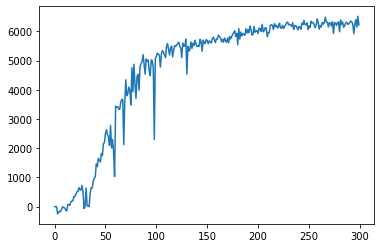

In [7]:
import matplotlib.pyplot as plt
plt.plot(eval_scores)

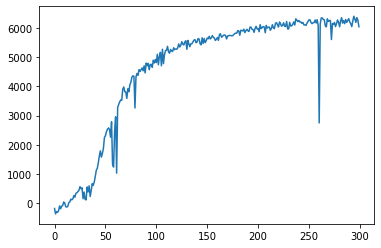

In [8]:
plt.plot(training_scores)

In [46]:
## 리스토어 버전

# import time
# tf.reset_default_graph()
env.close()
env = gym.make(GAME_NAME)
eval_env = gym.make(GAME_NAME)

# sess = tf.Session()
# agent = Agent()

# sess.run(tf.global_variables_initializer())
# agent.q_initial_sync()
## TRAIN ##
# eval_scores = []
# training_scores = []
for episode in range(MAX_EPISODE-192):
    state = env.reset()

#     eps = [[np.random.normal(agent.action_dim)]]
#     aa = sess.run(agent.action, feed_dict={agent.state_ph:[state], agent.action_eps_ph:eps})
#     d=sess.run(agent.log_policy, feed_dict={agent.state_ph:[state], agent.action_ph:aa, agent.action_eps_ph:eps})
#     print('d',d)
#     print('sat',state)
    score = 0
    step = 0
    while True:
        action, ua = agent.sample_action(state)
        print()
#         if episode%10==0:
#             env.render()
#             time.sleep(0.01)
        next_state, reward, done, info = env.step(action[0])
        fake_done = False
        time.sleep(.002)
#         env.render()
#         time.sleep(0.01)
        agent.replay.update(state, action[0], [reward], next_state, [fake_done])
#         print('nn',next_state)
        qloss, ploss = agent.train()


        step += 1
        score += reward
        state = next_state
        if done or step>2000:
            training_scores.append(score)
            print('step', step, 'score', score, 'qloss', qloss,'ploss',ploss)
            print('ac', action, 'ua', ua)
            print
            break
    
    eval_score = agent.evaluate()
    eval_scores.append(eval_score)

    





[ 5.89449114e-02  8.24127793e-03 -9.08056190e-02 -6.14158210e-03
  9.83831413e-02 -4.98359380e-02  8.56840804e-02 -4.62104376e-02
  7.98437363e-02 -2.06938379e-01  4.54899636e-02 -8.23456727e-02
  1.65275783e-01 -2.42939989e-02  8.69395109e-02  1.34701536e-04
  9.08832051e-03]


MujocoException: Unknown warning type Time = 0.0000.Check for NaN in simulation.